In [ ]:
import time
from typing import Tuple
import numpy as np
import pandas as pd
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision.transforms import transforms
from torchvision import models
from dataclasses import dataclass
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

In [9]:
@dataclass
class State:
    frame: torch.Tensor
    sp: float       # stamina points
    zoom: int

@dataclass
class Action:
    direction: int
    time_steps: int

# Check if frame has stone
def check_frame(self, frame) -> bool:
    crops = []
    for i in range(4):
        for j in range(4):
            crop = torchvision.transforms.functional.crop(frame, i * 24, j * 24, 24, 24)[None]
            crops.append(crop)
    expected_stone = self.stone_classifier(torch.cat(crops)).max(dim=0)[0][1].item()
    return expected_stone > 0.5

def find_state_with_stone(df: pd.DataFrame, max_attempt: int = 10) -> State:
    while True:
        index = np.random.randint(0, len(df) - 1)
        frame = load_image(df["video"][index], df["frame"][index])
        train_aug = A.Compose([A.Normalize(mean=(0.5,), std=(0.5,)),
                               ToTensorV2(transpose_mask=False),
                               ])
        frame = train_aug(image=frame)['image']
        if env.check_frame(frame):
            break
    sp = df["sp"][index]
    zoom = df["zoom"][index]
    state = State(frame, sp, zoom)
    return state

def see_plot(pict, size=(6, 6), title: str = None):
    plt.figure(figsize=size)
    plt.imshow(pict, cmap='gray')
    if title is not None:
        plt.title(title)
    plt.show()

def load_image(video, frame):
    path = "../surviv_rl_data/all_videoframes_rgb_96/{}/".format(video)
    p = cv2.imread(path + 'f_{}.jpg'.format(frame))
    return p[:, :, ::-1]

In [3]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )


class ResNetUNet_v2(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.base_model = models.resnet18(pretrained=True)

        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3])  # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5])  # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)
        self.dropout = nn.Dropout(0.5)
        self.conv_last = nn.Conv2d(64, n_class, 1)
        self.act_last = nn.Tanh()
        self.support_conv1 = nn.Conv2d(11, 512, 1)  # (bath,10+1) --> (batch,512)

    def forward(self, inp):
        x_original = self.conv_original_size0(inp[0])
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(inp[0])
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        cond = self.support_conv1(torch.unsqueeze(torch.unsqueeze(inp[1], 2), 2))  # ([8, 8]) --> Size([8, 512, 1, 1])
        layer4 = self.layer4_1x1(layer4 + cond)

        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        x = self.dropout(x)
        out = self.conv_last(x)
        out = self.act_last(out)

        return out

In [4]:
class StoneClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, 2, 1)
        self.conv2 = nn.Conv2d(8, 16, 3, 2, 1)
        self.conv3 = nn.Conv2d(16, 32, 3, 2, 1)
        self.fc1 = nn.Linear(32 * 3 * 3, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

In [5]:
class NeuralEnv:
    def __init__(self, env_model_path: str, reward_model_path: str, device: str):
        self.model = ResNetUNet_v2(3)
        self.model.load_state_dict(torch.load(env_model_path, map_location=torch.device(device)))
        self.model.eval()
        self.stone_classifier = StoneClassifier()
        self.stone_classifier.load_state_dict(torch.load(reward_model_path, map_location=torch.device(device)))
        self.stone_classifier.eval()

    def step(self, state: State, action: Action) -> Tuple[State, float]:
        d = F.one_hot(torch.tensor(action.direction - 1), num_classes=8)
        sp = torch.tensor(state.sp) / 100
        zoom = torch.tensor(state.zoom) / 15
        n = torch.tensor(action.time_steps / 14)
        dd2 = torch.cat([d,
                         sp.unsqueeze(0),
                         zoom.unsqueeze(0),
                         n.unsqueeze(0)]).unsqueeze(0).float()
        with torch.no_grad():
            frame = torch.clone(state.frame).unsqueeze(0)
            params = frame, dd2
            new_frame = self.model(params)[0].detach()
        return State(new_frame, state.sp, state.zoom), self._reward(new_frame)

    def reset(self):
        pass

    def _reward(self, frame) -> float:
        transform = transforms.Compose(
            [
                transforms.CenterCrop(24)
            ]
        )
        return self.stone_classifier(transform(frame[None]))[0][1].item()

In [15]:
env = NeuralEnv("../best_models/resunet_v5.pth", "../best_models/nostone_stone_classifier.pth", "cpu")

In [16]:
def test_env(env):
    df = pd.read_csv("../surviv_rl_data/dataset_inventory_v2.csv")
    df = df[df.zoom == 1].reset_index()

    i = 925
    # i = np.random.randint(len(df))
    frame = load_image(df["video"][i], df["frame"][i])
    train_aug = A.Compose([A.Normalize(mean=(0.5,), std=(0.5,)),
                           ToTensorV2(transpose_mask=False),
                           ])
    frame = train_aug(image=frame)['image']
    sp = df["sp"][i]
    zoom = df["zoom"][i]
    state = State(frame, sp, zoom)
    cum_reward = 0
    for i in range(10):
        d = np.random.randint(1, 8)
        n = np.random.randint(1, 14)
        action = Action(d, n)
        state, reward = env.step(state, action)
        cum_reward += reward
        next_frame = state.frame.permute(1, 2, 0).cpu().detach().numpy() / 2 + 0.5
        display.clear_output(wait=True)
        see_plot(next_frame, (5, 5), f"Reward: {cum_reward:.2f}")
        time.sleep(0.1)

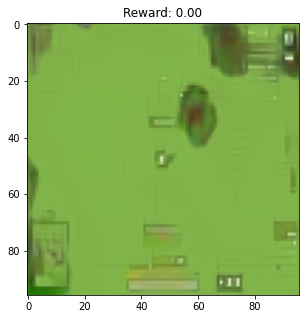

In [17]:
test_env(env)